### Predicting the 2024 NBA Playoffs 

We base our model off of the Yale Undergraduate Sports Analytics Group (YUSAG): 
- [Yale NBA Model Math](https://sports.sites.yale.edu/nba-model-math)
- [Yale NBA End-of-Season Predictions](https://sports.sites.yale.edu/r-nba-end-season-predictions)

#### Step 1: Getting Team Data

Get data for games from the 2023-2024 NBA season. 

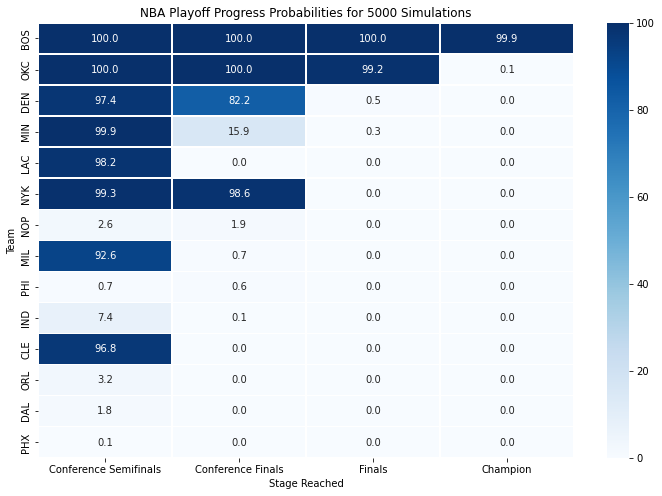

In [11]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import leaguestandings
from collections import defaultdict
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_game_data():
    """returns a dataframe containing data on games from the most recent NBA season"""

    season_data = leaguegamefinder.LeagueGameFinder(
        season_nullable='2023-24', 
        season_type_nullable='Regular Season',
        league_id_nullable='00'  # nba only
    )

    season_df = season_data.get_data_frames()[0]

    season_df['LOCATION'] = season_df['MATCHUP'].apply(
        lambda m: 'H' if 'vs.' in m else 'A'
    )

    def get_opponent_from_matchup(matchup: str):
        if 'vs.' in matchup:
            return matchup.partition('vs.')[2].strip()
        return matchup.partition('@')[2].strip()

    season_df['OPPONENT'] = season_df['MATCHUP'].apply(get_opponent_from_matchup)

    columns_of_interest = ['GAME_DATE', 'TEAM_ABBREVIATION', 'OPPONENT', 'LOCATION', 'WL', 'PTS', 'PLUS_MINUS']

    cleaned_df = season_df[columns_of_interest].copy()
    cleaned_df.rename(
        columns={'TEAM_ABBREVIATION': 'TEAM'}, 
        inplace=True
    )

    return cleaned_df


def get_playoff_teams():
    team_abbreviations = {
        'Celtics': 'BOS',
        'Cavaliers': 'CLE',
        'Mavericks': 'DAL',
        'Nuggets': 'DEN',
        'Pacers': 'IND',
        'Clippers': 'LAC',
        'Lakers': 'LAL',
        'Heat': 'MIA',
        'Bucks': 'MIL',
        'Timberwolves': 'MIN',
        'Pelicans': 'NOP',
        'Knicks': 'NYK',
        'Thunder': 'OKC',
        'Magic': 'ORL',
        '76ers': 'PHI',
        'Suns': 'PHX',
    }

    standings = leaguestandings.LeagueStandings()
    standings_df = standings.get_data_frames()[0]

    eastern_conf_teams = list(standings_df[standings_df['Conference'] == 'East'].iloc[:8]['TeamName'])
    eastern_conf_teams = [team_abbreviations[t] for t in eastern_conf_teams]

    western_conf_teams = list(standings_df[standings_df['Conference'] == 'West'].iloc[:8]['TeamName'])
    western_conf_teams = [team_abbreviations[t] for t in western_conf_teams]

    return eastern_conf_teams, western_conf_teams


nba_game_df = get_game_data()

# use ordinary least squares to perform linear regression of 
# plus_minus based on team, opponent, and location
model = smf.ols('PLUS_MINUS ~ TEAM + OPPONENT + LOCATION', data=nba_game_df).fit()

TEAM_COEFFS = model.params.filter(regex='^TEAM')
TEAM_COEFFS = TEAM_COEFFS - TEAM_COEFFS.mean()  # so that a coefficient of 0 represents the avg team
HOME_ADVANTAGE = model.params['LOCATION[T.H]']
EAST_TEAMS, WEST_TEAMS = get_playoff_teams()
NUM_SIMULATIONS = 5000

def win_probability(team, opponent, location):
    team_coef = TEAM_COEFFS[f'TEAM[T.{team}]']
    opponent_coef = TEAM_COEFFS[f'TEAM[T.{opponent}]']
    
    point_diff = team_coef - opponent_coef + (HOME_ADVANTAGE if location == 'H' else -HOME_ADVANTAGE)

    # Calculate win prob as function of point difference using the logistic function
    probability = 1 / (1 + np.exp(-point_diff))
    return probability


def simulate_game(team1, team2, location):
    prob_team1_wins = win_probability(team1, team2, location)
    return np.random.rand() < prob_team1_wins


# simulate best of 7 series
def simulate_series(team1, team2):
    team1_wins = 0
    team2_wins = 0
    game = 0

    while team1_wins < 4 and team2_wins < 4:
        if game < 2:  
            winner = simulate_game(team1, team2, 'H')
        elif game < 4:  
            winner = simulate_game(team1, team2, 'A')
        else: 
            location = 'H' if game % 2 == 0 else 'A'
            winner = simulate_game(team1, team2, location)

        if winner:
            team1_wins += 1
        else:
            team2_wins += 1
        
        game += 1
    
    return team1 if team1_wins == 4 else team2


def simulate_playoffs():
    playoff_progress = {}

    # first round
    winners_east = [simulate_series(EAST_TEAMS[i], EAST_TEAMS[-i-1]) for i in range(4)]
    winners_west = [simulate_series(WEST_TEAMS[i], WEST_TEAMS[-i-1]) for i in range(4)]

    # conference semi-finals
    for team in winners_east + winners_west:
        playoff_progress[team] = 'Conference Semi-Finals'
    semi_finals_east = [simulate_series(winners_east[i], winners_east[-i-1]) for i in range(2)]
    semi_finals_west = [simulate_series(winners_west[i], winners_west[-i-1]) for i in range(2)]

    # conference finals
    for team in semi_finals_east + semi_finals_west:
        playoff_progress[team] = 'Conference Finals'
    east_champion = simulate_series(semi_finals_east[0], semi_finals_east[1])
    west_champion = simulate_series(semi_finals_west[0], semi_finals_west[1])

    # NBA finals
    playoff_progress[east_champion] = 'Finals'
    playoff_progress[west_champion] = 'Finals'
    champion = simulate_series(east_champion, west_champion)

    playoff_progress[champion] = 'Champion'
    return playoff_progress


def get_playoff_odds(num_simulations):
    stage_counts = defaultdict(lambda: defaultdict(int))
    
    for _ in range(num_simulations):
        progress = simulate_playoffs()
        for team, stage_reached in progress.items():
            if stage_reached == 'Champion':
                stage_counts[team]['Champion'] += 1
                stage_counts[team]['Finals'] += 1
                stage_counts[team]['Conference Finals'] += 1
                stage_counts[team]['Conference Semifinals'] += 1
            elif stage_reached == 'Finals':
                stage_counts[team]['Finals'] += 1
                stage_counts[team]['Conference Finals'] += 1
                stage_counts[team]['Conference Semifinals'] += 1
            elif stage_reached == 'Conference Finals':
                stage_counts[team]['Conference Finals'] += 1
                stage_counts[team]['Conference Semifinals'] += 1
            else:
                stage_counts[team]['Conference Semifinals'] += 1
    
    # Convert counts to probabilities
    playoff_odds = defaultdict(dict)

    for team, stages in stage_counts.items():
        for stage, count in stages.items():
            playoff_odds[team][stage] = count / num_simulations
    
    return playoff_odds


playoff_data = get_playoff_odds(10000)
df = pd.DataFrame.from_dict(playoff_data, orient='index', columns=['Conference Semifinals', 'Conference Finals', 'Finals', 'Champion'])
df.fillna(0, inplace=True) 
df.sort_values(by=['Champion', 'Finals', 'Conference Finals', 'Conference Semifinals'], ascending=False, inplace=True)
df = df * 100  # use percentages for readability


# visualize using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5, cmap="Blues")
plt.title(f'NBA Playoff Progress Probabilities for {NUM_SIMULATIONS} Simulations')
plt.ylabel('Team')
plt.xlabel('Stage Reached')
plt.show()